In [1]:
# !pip install beautifulsoup4
# !pip install emoji
# !pip install transformers

In [2]:
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
import opendatasets as op
warnings.filterwarnings('ignore')

import tensorflow

pd.set_option("display.max_columns", None)

In [3]:
df_train = pd.read_csv("gomotions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [4]:
df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))

In [5]:
with open('gomotions/data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [6]:
emotion_file = open("gomotions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [7]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [8]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)


In [17]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['love']:
            map_list.append('love')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [18]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)


NameError: name 'map_list' is not defined

In [11]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

In [12]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [13]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [14]:
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)

In [15]:
df_train.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

In [16]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [17]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

In [18]:
def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text


In [19]:
def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [20]:
def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [21]:
def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

In [22]:
def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [23]:
df_train.reset_index(drop=True).to_csv("train.csv", index=False)

In [24]:
df_train = df_train.reset_index(drop=True)

In [25]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'fear', 'joy', 'sadness', 'surprise']

In [28]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_train,test_size=0.3,random_state=101,shuffle=True)

In [29]:
Y_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']
X_train = train_data["Text"]
Y_train = train_data[target_cols]
X_test = test_data["Text"]
Y_test = test_data[target_cols]

In [30]:
X_train.shape, X_test.shape

((19898,), (8529,))

In [31]:
X_train

19290    Your description fits the type of SB I prefer....
14870    Thanks man I appreciate that! I just feel like...
2647                            What will you gain from it
14443    I was getting arrested and my dog run away fro...
5915     I'm really proud of you for standing up yourse...
                               ...                        
5695     Are ya completely sure that's not from that Th...
8006     I like that they have a red light camera there...
17745                          THEY ARE SO CUTE TOGETHER!!
17931    Oh god no!!! I was gonna get some shipped out ...
13151    [NAME], you're back! And still posting the sam...
Name: Text, Length: 19898, dtype: object

In [32]:
train_data

,Text,ID,anger,fear,joy,sadness,surprise
19290,Your description fits the type of SB I prefer....,eey2yxs,0,0,1,0,0
14870,Thanks man I appreciate that! I just feel like...,ed0mff3,0,0,1,0,1
2647,What will you gain from it,eedl6e1,0,0,0,0,1
14443,I was getting arrested and my dog run away fro...,eeoiiuu,0,0,0,1,0
5915,I'm really proud of you for standing up yourse...,edt4zhs,0,0,1,0,0
...,...,...,...,...,...,...,...
5695,Are ya completely sure that's not from that Th...,eea7qa1,0,0,1,0,0
8006,I like that they have a red light camera there...,edr6xko,0,0,1,0,0
17745,THEY ARE SO CUTE TOGETHER!!,eeslgjt,0,0,1,0,0
17931,Oh god no!!! I was gonna get some shipped out ...,eev671h,0,0,0,0,1


In [33]:
# set parameters:
vocab_size = 1000
maxlen = 300
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 128
epochs = 20

In [34]:
# Tokenizer: Ensures inputs that are longer than max vocab size are removed to ensure same size vectors
from keras.preprocessing import text
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [35]:
from keras.utils import pad_sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [36]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [37]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [38]:
# Model
from keras.models import Sequential
from keras.layers import Embedding, LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, Flatten, MaxPooling1D, GlobalMaxPool1D


model = Sequential()
model.add(Embedding(vocab_size,
                    100,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(128,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(target_cols), activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 64)           0         
 1D)                                                    

In [41]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.000001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [84]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

Epoch 1/20
622/622 [==============================] - 29s 47ms/step - loss: 1.5887 - accuracy: 0.5727 - val_loss: 1.5968 - val_accuracy: 0.5771
Epoch 2/20
622/622 [==============================] - 32s 52ms/step - loss: 1.5859 - accuracy: 0.5722 - val_loss: 1.5948 - val_accuracy: 0.5771
Epoch 3/20
622/622 [==============================] - 30s 48ms/step - loss: 1.5837 - accuracy: 0.5724 - val_loss: 1.5927 - val_accuracy: 0.5771
Epoch 4/20
622/622 [==============================] - 30s 49ms/step - loss: 1.5828 - accuracy: 0.5728 - val_loss: 1.5907 - val_accuracy: 0.5771
Epoch 5/20
622/622 [==============================] - 30s 49ms/step - loss: 1.5799 - accuracy: 0.5723 - val_loss: 1.5885 - val_accuracy: 0.5771
Epoch 6/20
622/622 [==============================] - 31s 49ms/step - loss: 1.5762 - accuracy: 0.5721 - val_loss: 1.5864 - val_accuracy: 0.5771
Epoch 7/20
622/622 [==============================] - 31s 50ms/step - loss: 1.5734 - accuracy: 0.5720 - val_loss: 1.5843 - val_accuracy:

In [43]:
!pip install pyyaml h5py

In [44]:
# model.save('gomotions/models/CNN_glove_model.h5')

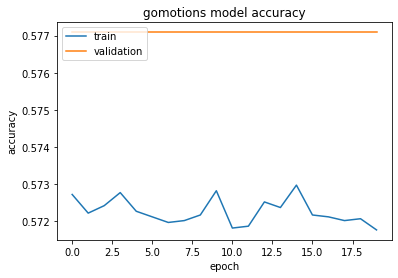

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('gomotions model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


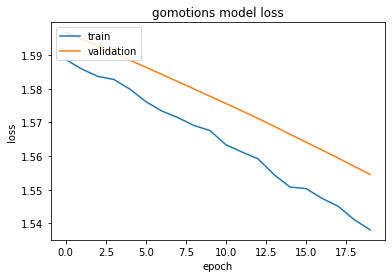

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('gomotions model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [103]:
predictions = model.predict(X_test)

267/267 [==============================] - 2s 8ms/step


In [104]:
predictions

array([[0.51831317, 0.47921917, 0.57827616, 0.507039  , 0.51883733],
       [0.8956779 , 0.43739945, 0.95038533, 0.8170732 , 0.8734654 ],
       [0.51831317, 0.47921917, 0.57827616, 0.507039  , 0.51883733],
       ...,
       [0.51831317, 0.47921917, 0.57827616, 0.507039  , 0.51883733],
       [0.51831317, 0.47921917, 0.57827616, 0.507039  , 0.51883733],
       [0.51831317, 0.47921917, 0.57827616, 0.507039  , 0.51883733]],
      dtype=float32)

In [110]:
from sklearn.metrics import confusion_matrix
matrix = metrics.confusion_matrix(Y_test, predictions)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets